# 簡介
本篇處於開發階段，主要受到[Edan](https://github.com/emarco177/langgraph-customer-support/blob/main/support_agent/graph.py)啟發，想要逐步開發使用者資訊收集並用 LangGRaph 開發。

##故事背景是這樣：
開發客服機器人時，會遇到一個狀況是，系統需要確認使用者的個人身份驗證是否正確。
這時候使用者需要掏出他的名稱、電話、身分證字號等，但事情沒有憨人想的這麼簡單，有時候只有填寫部分資訊，例如說只有給電話號碼而已。這個在程序上很麻煩，所以需要使用者反覆填寫一直到，客服機器人確認可行之後，才放行離開。

## 章節一、收集使用者資訊

### 環境建置

In [ ]:
%pip install --upgrade --quiet langchain
%pip install --upgrade --quiet langchain-openai
%pip install --upgrade --quiet langgraph
%pip install --upgrade --quiet langchain-community

In [ ]:
import os
import getpass
from google.colab import userdata

os.environ["OPENAI_API_KEY"] = userdata.get('OPENAI_API_KEY')

## 設計流程

說明：這邊我們需要建立幾個節點，收集使用者之後之外，也需要交給節點去判斷是否滿足完整資訊，玩整資訊，

![上設計圖](https://i.imgur.com/ILV11yi.png)


## 定義狀態

In [ ]:
from typing import Annotated, Optional, TypedDict

from langchain_core.pydantic_v1 import BaseModel, Field
from langgraph.graph import add_messages

## 定義使用者資訊
class RequiredInformation(BaseModel):
    provided_full_name: Optional[str] = Field(
        description="the provided full name of the user"
    )
    provided_mobile: Optional[str] = Field(
        description="the provided mobile number of the user"
    )
    provided_id_4_digits: Optional[int] = Field(
        description="the provided user last 4 digits of id card"
    )


## 定義 Graph 中狀態管理
class AssistantGraphState(TypedDict):
    user_question: str
    required_information: RequiredInformation
    messages: Annotated[list, add_messages]

## 定義節點函數

### 測試助理節點

In [ ]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI

# 定義系統提示
system = """你是 AI 客服助理。你的任務是收集必要的用戶資訊。請遵循以下原則:

1. 保持禮貌和專業,使用適當的敬語。
2. 如果用戶詢問的資訊不完整,請適當地要求補充。
3. 在收集用戶資訊時,請確保隱私和安全。
4. 如果無法回答某個問題,請誠實地表示,並提供其他可能的幫助方式。


需要收集的資訊包括：

class RequiredInformation(BaseModel):
    provided_full_name: Optional[str] = Field(
        description="the provided full name of the user"
    )
    provided_mobile: Optional[str] = Field(
        description="the provided mobile number of the user"
    )
    provided_id_4_digits: Optional[int] = Field(
        description="the provided user last 4 digits of id card"
    )

請確保每項資訊都符合要求後再進行下一項。

DO NOT FILL IN THE USERS INFORMATION, YOU NEED TO COLLECT IT.

請根據用戶的問題和已提供的資訊,給出適當的回應和指引。"""

# 創建助理提示模板
assistant_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        (
            "human",
            "User question: {user_question}\n"
            "Chat history: {messages}\n"
            "\n\n What the user have provided so far {provided_required_information} \n\n"
        ),
    ]
)

# 初始化語言模型
llm = ChatOpenAI(model="gpt-3.5-turbo-0125", temperature=0.7)

get_information_chain = assistant_prompt | llm
res = get_information_chain.invoke(
    {
        "user_question": "我想購買高鐵車票",
        "provided_required_information": {}, # 這邊資訊主要來自於 AssistantGraphState["required_information"]
        "messages": [],
    }
)
print(res.content)

您好，感謝您的詢問。在購買高鐵車票之前，我們需要您提供一些個人資訊，以便完成訂票。請您提供以下資訊：
1. 您的全名
2. 聯絡電話號碼
3. 身份證末四碼

請提供這些資訊後，我們將幫助您完成高鐵車票的購買。感謝您的配合。


### 測試 collect_info_LLM，輸入 prompt 要求將資訊提取出來，並且使用 strudtured_output

In [ ]:
# 使用 OpenAI 模型
llm = ChatOpenAI(model="gpt-3.5-turbo-0125", temperature=0)

# 資訊收集 Chain
collect_info_system = """你是 AI 客服助理。你的任務是收集必要的用戶資訊。請遵循以下原則:

1. 保持禮貌和專業,使用適當的敬語。
2. 如果用戶詢問的資訊不完整,請適當地要求補充。
3. 在收集用戶資訊時,請確保隱私和安全。
4. 如果無法回答某個問題,請誠實地表示,並提供其他可能的幫助方式。


需要收集的資訊包括：

class RequiredInformation(BaseModel):
    provided_full_name: Optional[str] = Field(
        description="the provided full name of the user"
    )
    provided_mobile: Optional[str] = Field(
        description="the provided mobile number of the user"
    )
    provided_id_4_digits: Optional[int] = Field(
        description="the provided user last 4 digits of id card"
    )

請確保每項資訊都符合要求後再進行下一項。

DO NOT FILL IN THE USERS INFORMATION, YOU NEED TO COLLECT IT.

請根據用戶的問題和已提供的資訊,給出適當的回應和指引。
"""

collect_info_prompt = ChatPromptTemplate.from_messages([
    ("system", collect_info_system),
    (
        "human",
        "User question: {user_question}\n"
        "Chat history: {messages}\n"
        "\n\n What the user have provided so far {provided_required_information} \n\n"
    ),
])

collect_info_chain = collect_info_prompt | llm.with_structured_output(RequiredInformation)

# 測試資訊收集 Chain 的函數
def test_collect_info(user_input, messages = [], collected_info=None):
    if collected_info is None:
        collected_info = RequiredInformation()
    result = collect_info_chain.invoke({
        "user_question": user_input,
        "provided_required_information": collected_info,
        "messages": [],
    })
    print(f"用戶輸入: {user_input}")
    print(f"AI回應: {result}")
    print()

print("=== 測試資訊收集 Chain ===")
test_collect_info("我的名字是張小明")
test_collect_info("我的電話是0912345678")
test_collect_info("我的身分證末四碼是5678")

=== 測試資訊收集 Chain ===
用戶輸入: 我的名字是張小明
AI回應: provided_full_name='張小明' provided_mobile=None provided_id_4_digits=None

用戶輸入: 我的電話是0912345678
AI回應: provided_full_name=None provided_mobile='0912345678' provided_id_4_digits=None

用戶輸入: 我的身分證末四碼是5678
AI回應: provided_full_name=None provided_mobile=None provided_id_4_digits=None



### 建構 Responsde_builder

In [ ]:
from langchain.schema import HumanMessage, AIMessage

# 定義回應建構器的系統提示
response_builder_system = """
你是台灣高鐵的AI客服助理。你的任務是總結對話內容，並提供一個清晰、專業的回應給用戶。請遵循以下原則：

1. 總結已收集的用戶資訊（如果有的話）。
2. 簡要回顧對話中討論的主要問題或請求。
3. 提供任何相關的後續步驟或建議。
4. 使用禮貌和專業的語氣。
5. 如果有任何未完成的事項，請提醒用戶。

請確保你的回應簡潔但全面，並符合高鐵客服的專業標準。
"""

response_builder_prompt = ChatPromptTemplate.from_messages([
    ("system", response_builder_system),
    ("human", "用戶資訊：{user_info}\n對話歷史：{chat_history}\n請提供一個總結性的回應。")
])

llm = ChatOpenAI(model="gpt-3.5-turbo-0125", temperature=0.7)

response_chain = response_builder_prompt | llm


# 模擬用戶資訊
user_info = {
    "provided_full_name": "張小明",
    "provided_mobile": "0912345678",
    "provided_id_4_digits": "5678"
}

# 模擬對話歷史
chat_history = [
    HumanMessage(content="我想訂購一張從台北到高雄的票"),
    AIMessage(content="好的,我可以協助您訂購從台北到高雄的高鐵票。請問您想要哪一天的票？"),
    HumanMessage(content="我想要明天下午 3 點左右的票"),
    AIMessage(content="了解,我會為您查詢明天下午 3 點左右從台北到高雄的車次。在此之前,請問您是否有高鐵會員卡？"),
    HumanMessage(content="沒有,我不是會員"),
    AIMessage(content="沒關係,我們可以繼續為您訂票。根據您提供的時間,有一班 15:00 的車次,預計 17:36 抵達高雄。這班車次適合您嗎？"),
    HumanMessage(content="好的,就訂這班車吧"),
]

# 將對話歷史轉換為字符串
chat_history_str = "\n".join([f"{msg.type}: {msg.content}" for msg in chat_history])

# 調用 response chain
summary_response = response_chain.invoke({
    "user_info": user_info,
    "chat_history": chat_history_str
})

# 打印結果
print("生成的回應總結:")
print(summary_response.content)

生成的回應總結:
根據您提供的資訊，您想訂購一張明天下午 3 點左右從台北到高雄的高鐵票，並且確認了班次為 15:00 從台北出發、17:36 抵達高雄的車次。您已確認訂購這班車次。請記得攜帶有效身分證明文件及訂票所需的相關資訊。祝您旅途愉快！如果需要進一步協助，請隨時與我們聯繫。


### 定義流程控制函數

In [ ]:
from typing import Literal

def provided_all_details(state: AssistantGraphState) -> Literal["info all collected", "not fulfill"]:
    if "required_information" not in state:
        return "not fulfill"
    provided_information: RequiredInformation = state["required_information"]
    if (
        provided_information.provided_full_name
        and provided_information.provided_mobile
        and provided_information.provided_id_4_digits
    ):
        return "info all collected"

    else:
        return "not fulfill"

### 修改 Chain 成為 Node

In [ ]:
from typing import Any, Dict, List
from langchain_core.messages import HumanMessage

# 定義助理節點函數
def assistant_chain_func(state: AssistantGraphState) -> Dict[str, Any]:
    get_information_chain = assistant_prompt | llm

    res = get_information_chain.invoke(
        {
            "user_question": state["user_question"],
            "provided_required_information": state["required_information"],
            "messages": state["messages"] if "messages" in state else [],
        }
    )

    # 更新狀態
    updated_state = state.copy()
    updated_state["messages"] = state.get("messages", []) + [res]

    return updated_state

## 檢查收集的資訊是否充足
def combine_required_info(info_list: List[RequiredInformation]) -> RequiredInformation:
    info_list = [info for info in info_list if info is not None]

    if len(info_list) == 1:
        return info_list[0]
    combined_info = {}
    for info in info_list:
        for key, value in info.dict().items():
            if value is not None:
                combined_info[key] = value
    return RequiredInformation(**combined_info)

def collect_info_chain_func(state: AssistantGraphState) -> AssistantGraphState:
    """
    收集用戶資訊，驗證，並更新 AssistantGraphState。

    參數:
    state (AssistantGraphState): 當前的助理狀態

    返回:
    AssistantGraphState: 更新後的助理狀態

    說明:
    1. 從標準輸入獲取用戶提供的資訊
    2. 調用 collect_info_chain 處理用戶輸入和當前狀態
    3. 驗證新收集的資訊
    4. 合併新收集的資訊與現有資訊（如果存在）
    5. 更新並返回新的狀態，包括更新後的必要資訊和消息歷史
    """
    # 從標準輸入獲取用戶資訊
    information_from_stdin = str(input("\n輸入用戶資訊：\n"))

    # 調用 collect_info_chain 處理用戶輸入
    response = collect_info_chain.invoke(
        {
          "user_question": state["user_question"],
          "provided_required_information": information_from_stdin,
          "messages": state["messages"],
        }
    )

    # 合併新收集的資訊與現有資訊
    if "required_information" in state:
        required_info = combine_required_info(
            info_list=[response, state.get("required_information")]
        )
    else:
        required_info = response

    # 返回更新後的狀態
    return {
        "required_information": required_info,
        "messages": [HumanMessage(content=information_from_stdin)],
    }

def response_builder_func(state: Dict[str, Any]) -> Dict[str, Any]:
    # 提取用戶資訊
    user_info = state.get("required_information", {})
    if hasattr(user_info, 'dict'):
        user_info = user_info.dict()

    # 提取對話歷史
    chat_history = state.get("messages", [])
    chat_history_str = "\n".join([f"{msg.type}: {msg.content}" for msg in chat_history if hasattr(msg, 'type') and hasattr(msg, 'content')])

    # 生成總結回應
    response_chain = response_builder_prompt | llm
    summary_response = response_chain.invoke({
        "user_info": user_info,
        "chat_history": chat_history_str
    })

    # 更新狀態
    updated_state = state.copy()
    updated_state["final_response"] = summary_response.content
    updated_state["messages"] = chat_history + [summary_response]

    return updated_state

### 編譯整張圖

In [ ]:
# 定義節點名稱
ASSISTANT_NODE = "assistant_node"
COLLECT_INFO_NODE = "collect_info_node"
RESPONSE_BUILDER_NODE = "response_builder_node"

# 改採策略，逐一增加節點，先從 START -> route -> END
from langgraph.graph import START, END, StateGraph

workflow = StateGraph(AssistantGraphState)

# 添加節點
workflow.add_node("assistant_node", assistant_chain_func)
workflow.add_node("collect_info_node", collect_info_chain_func)
workflow.add_node("response_builder_node", response_builder_func)


# 添加邊
workflow.add_edge(START, "assistant_node" )
workflow.add_edge("assistant_node", "collect_info_node")
workflow.add_conditional_edges(
    "collect_info_node",
    provided_all_details,
    {
        "info all collected": "response_builder_node",
        "not fulfill": "assistant_node"
    }
)
workflow.add_edge("response_builder_node", END)


# 編譯
app = workflow.compile()

## 視覺化整張圖出來

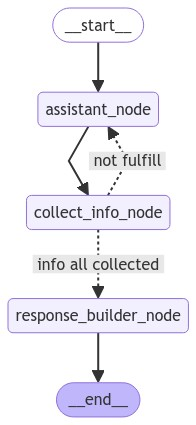

In [ ]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph(xray=True).draw_mermaid_png()))
except:
    pass

### 與之互動

In [ ]:
import rich

init_state = AssistantGraphState(
    user_question="我想訂購高鐵票",
    required_information=RequiredInformation(),
    messages=[],
)

for output in app.stream(
        init_state,
        config={"configurable": {"thread_id": 888}}
    ):
        for key, value in output.items():
            if "messages" in value:
                try:
                    last_msg = value["messages"][-1]
                    last_msg.pretty_print()
                except Exception as e:
                    print(f"last_msg:{last_msg}")

================================== Ai Message ==================================

感謝您想訂購高鐵票。在開始訂購之前，我們需要您提供一些必要的資訊。請您提供您的姓名、手機號碼以及身份證末四碼，以便我們完成訂購程序。請提供這些資訊後我們可以為您安排訂票事宜。

輸入用戶資訊：
我叫李大強
================================ Human Message =================================

我叫李大強
================================== Ai Message ==================================

感謝您提供姓名為李大強，接下來，我們還需要您的手機號碼和身份證末四碼。請您提供這些資訊以便我們完成訂票程序。謝謝您的配合！

輸入用戶資訊：
0988168168
================================ Human Message =================================

0988168168
================================== Ai Message ==================================

感謝您提供姓名和手機號碼。為了完成訂購高鐵票的程序，請您再提供一下您的身份證末四碼。這樣我們就可以為您安排訂票事宜。謝謝您的配合！

輸入用戶資訊：
9988
================================ Human Message =================================

9988
================================== Ai Message ==================================

感謝您提供姓名和手機號碼。為了完成訂購高鐵票的程序，請您再提供一下您的身份證末四碼。這樣我們就可以為您安排訂票事宜。請提供您的身份證末四碼，謝謝您的配合！

輸入用戶資訊：
末四碼 9988
================================ Human Mess